## Load Data & Pre-processing

In [8]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# 1. Load Data
df = pd.read_csv('data_manual.csv')

# 2. Preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text

df['clean_text'] = df['text'].apply(preprocess_text)

# Daftar stopword sederhana (Bahasa Indonesia)
stopwords_ind = [
    'dan', 'di', 'ke', 'dari', 'yang', 'pada', 'adalah', 'ini', 'itu', 'untuk',
    'bisa', 'ada', 'karena', 'kalau', 'jika', 'dengan', 'saya', 'kamu', 'dia',
    'mereka', 'kita', 'tidak', 'yg', 'ya', 'aja', 'aku', 'gak', 'bukan', 'sudah',
    'lagi', 'mau', 'akan', 'tapi', 'saja', 'juga', 'kok', 'kah', 'pun', 'n', 'tuh'
]

## K-Means & Modelling

In [9]:
print("--- K-Means Clustering ---")

# 1. Vectorization dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_ind, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Fit K-Means (Misal: 3 Cluster)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Masukkan label cluster ke dataframe
df['cluster'] = kmeans.labels_

# Tampilkan kata kunci per cluster
print("Top terms per cluster (K-Means):")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

# 3. TOPIC MODELLING (LDA)
print("\n--- Topic Modeling (LDA) ---")

# 4. Vectorization dengan Count Vectorizer (Bag of Words)
tf_vectorizer = CountVectorizer(stop_words=stopwords_ind, max_features=1000)
tf_matrix = tf_vectorizer.fit_transform(df['clean_text'])

# 5. Fit LDA (Misal: 3 Topik)
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tf_matrix)

# Tampilkan kata kunci per topik
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("Top words per topic (LDA):")
print_top_words(lda, tf_vectorizer.get_feature_names_out(), 10)

# Masukkan topik dominan ke dataframe
topic_values = lda.transform(tf_matrix)
df['topic'] = topic_values.argmax(axis=1)

# Simpan hasil
df.to_csv('data_manual_clustered_topics.csv', index=False)
print("\nSelesai. Hasil disimpan ke CSV.")

--- K-Means Clustering ---
Top terms per cluster (K-Means):
Cluster 0: naik, emas, terus, antam, nya, turun, harga, uang, rupiah, nilai
Cluster 1: beli, emas, jual, harga, turun, sekarang, toko, tahun, udah, tinggi
Cluster 2: emas, investasi, gram, juta, per, gr, dalam, paling, tahun, harga

--- Topic Modeling (LDA) ---
Top words per topic (LDA):
Topic #0: emas beli harga jual nya toko ga turun untung sekarang
Topic #1: emas beli harga uang naik turun jual investasi harganya gram
Topic #2: emas harga beli antam dunia kosong stok naik atau lebih

Selesai. Hasil disimpan ke CSV.


## Elbow

Menghitung inertia...
k=1, Inertia=288.32
k=2, Inertia=285.41
k=3, Inertia=283.49
k=4, Inertia=281.09
k=5, Inertia=279.60
k=6, Inertia=277.00
k=7, Inertia=275.89
k=8, Inertia=274.16
k=9, Inertia=272.56
k=10, Inertia=271.13


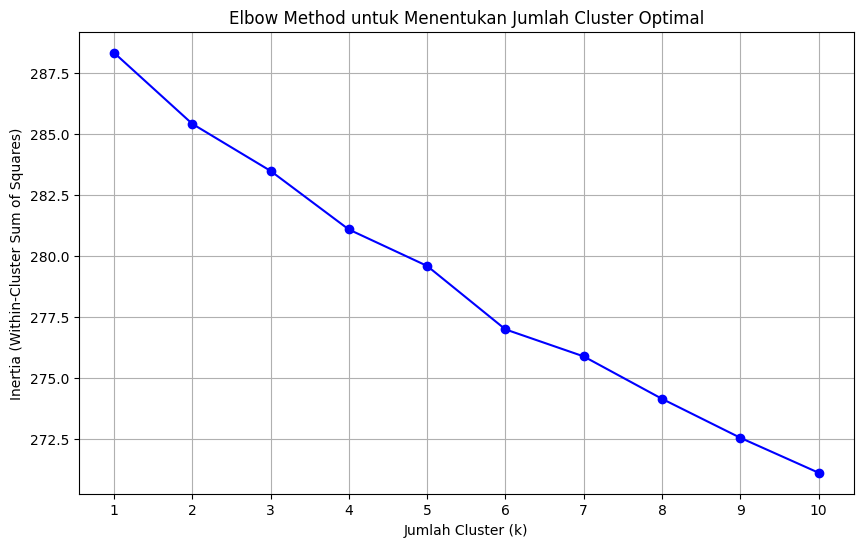

In [10]:
# 1. Vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_ind, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Hitung Elbow (Inertia untuk berbagai k)
inertias = []
K_range = range(1, 11)  # Coba k dari 1 sampai 10

print("Menghitung inertia...")
for k in K_range:
    # random_state agar hasil konsisten
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    print(f"k={k}, Inertia={kmeans.inertia_:.2f}")

# 3. Plot Grafik Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()